# Rigidity

How to set the minimum tracked rigidity in CRPropa?

In [1]:
import numpy as np
from astropy import units as u
from astropy import constants
import matplotlib.pyplot as plt  # version 3.5.1
import itertools

# Style plot
plt.rcParams.update({'font.size': 18, 
                     'figure.figsize': (12, 10), 
                     'axes.grid.which': 'both',
                     'grid.color': 'lightgrey', 
                     'grid.linestyle': 'dotted', 
                     'axes.grid': True, 
                     'axes.labelsize': 24,
                     'legend.fontsize': 16,
                     'ytick.minor.visible': True}
                   )
plt.style.use('tableau-colorblind10')
MARKERS = itertools.cycle(['o', 's', '^', 'D', 'd', 'X', 'h', 'x'])

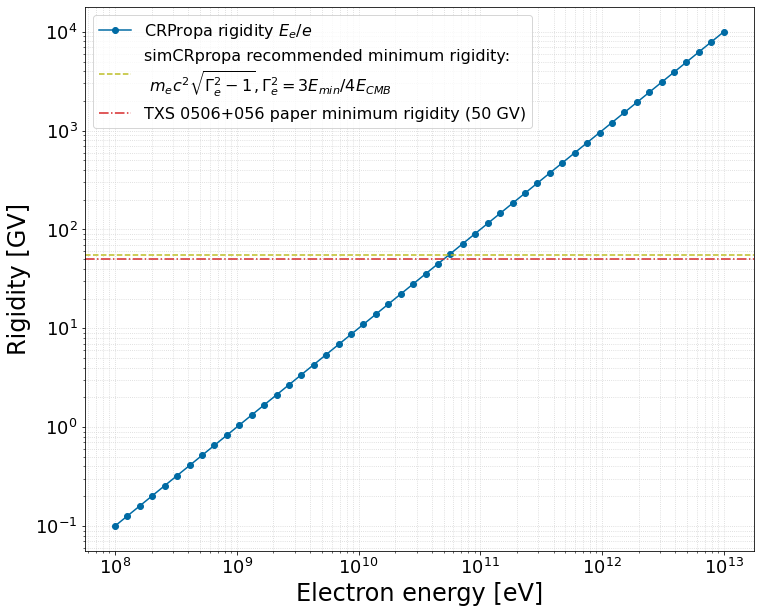

In [2]:
def get_rigidity(energy_joules):
    """Calculate rigidity in two ways:
    1. Using E/Z, the equation in CRPropa
       https://crpropa.github.io/CRPropa3/buildingblocks/Condition.html#_CPPv4N7crpropa15MinimumRigidityE
    2. Using the constraint in simCRpropa
       https://github.com/me-manu/simCRpropa/blob/56096ed4209e2a30e4452f95f70955c1b1187e32/simCRpropa/sim_crpropa.py#L821
    Input parameters must be in SI units because astropy.constants are in SI units.
    
    Parameters
    ----------
    electron_energy_joules : array_like[float] or float
        Electron/positron energy in Joules.
        
    Returns
    -------
    crpropa_rigidity_volts : array_like[float]
    simcrpropa_min_rigidity_volts : float  
    """
    
    # Rigidity in volts according to CRPropa docs
    # E/Z
    # All particles in simulations are electrons/positrons so Z=e
    crpropa_rigidity_volts = energy_joules / constants.e.si
    
    # Rigidity in volts according to simCRpropa comments
    # p c / q, where p c = m c^2 sqrt(gamma^2 - 1) and gamma^2 = Emin / CMBEnergy * 3 / 4
    # Longair High Energy Astrophysics has r = p c / q
    # Minimum tracked energy in eV
    emin_ev = 1e8
    # gamma^2
    simcrpropa_gamma2 = 3. / 4. * emin_ev / 634e-6 / 10.
    simcrpropa_min_rigidity_volts = constants.m_e.si * constants.c**2 * \
                                    np.sqrt(simcrpropa_gamma2 - 1) / constants.e.si

    return crpropa_rigidity_volts, simcrpropa_min_rigidity_volts


def plot_rigidity_vs_energy():
    """Plot rigidity in Volts vs electron/positron energy in eV."""
    # Create electron energies in eV over the simulation energies which are tracked or injected
    # Minimum tracked energy is 1e8 eV
    energy_arr_ev = np.logspace(8, 13)
    
    crpropa_r, simcrpropa_min_r = get_rigidity(u.eV.to(u.J, energy_arr_ev))
    
    plt.plot(energy_arr_ev, u.V.to(u.GV, crpropa_r), 
             marker=next(MARKERS), label=rf"CRPropa rigidity $E_e/e$")
    plt.axhline(u.V.to(u.GV, simcrpropa_min_r).value, 
                color="tab:olive", ls="--", 
                label="simCRpropa recommended minimum rigidity: \n $m_e c^2 \sqrt{\Gamma_e^2 - 1}, \Gamma_e^2 = 3 E_{min} / 4 E_{CMB}$")
    # From paper: "Probing a cosmogenic origin of astrophysical neutrinos and cosmic rays 
    # using gamma-ray observations of TXS 0506+056"
    # Submitted but not yet accepted with ADS url at time of writing this comment
    plt.axhline(50, 
                color="tab:red", ls="-.", 
                label="TXS 0506+056 paper minimum rigidity (50 GV)")
    plt.legend()
    plt.loglog()
    plt.xlabel('Electron energy [eV]')
    plt.ylabel(r'Rigidity [GV]')
    plt.show()
    
    
plot_rigidity_vs_energy()